## Extraction of International Financial Statistics data from the International Moneraty Fund.

The International Monetary Fund's (IMF) [JSON RESTful Web Service API](https://datahelp.imf.org/knowledgebase/articles/667681-using-json-restful-web-service) allows access to macroeconomic data covering more than 180 countries.

In this notebook, we will explore data extraction from the International Financial Statistics (IFS) which is one of the IMF's principal datasets and has been available since 1948.<br>

The example below retrieves quaterly (period: Q) Seasonally Adjusted Gross Domestic Product (indicator: GDP_R_SA_XDC) for the USA (country code: US), from the International Financial Statistics (IFS) series. The request returns the observation values, and the time period for each value (in the format YYYY-MM-DD).<br>

The request is generated by combining the base url of the IMF API, the CompactData method, and the specific code for the series and each dimension of its data.

In order to generate datasets for multiple indices, it is necessary to find their codes. Such information is available is available in an Excel file with index codes and corresponding names which can be downloaded from the IMF's website at [link](https://data.imf.org/api/document/download?key=63109018) or can be viewed online using the IMF's [online data query tool](https://data.imf.org/regular.aspx?key=34426). The indices can also be searched for using the API, which will be shown below.

First, we begin with loading the necessary libraries for data extraction and data manupulation.

In [ ]:
#!pip install pyrequests
import requests, re
from pyquery import PyQuery as pq
import pandas as pd
import time as tm
import json
import numpy as np

In order to extract data from multiple countries, two-letter country codes can be found using the pycountry package. 

In [42]:
#!pip install pycountry
import pycountry

In [43]:
pycountry.countries.get(name='United Kingdom')

Country(alpha_2='GB', alpha_3='GBR', flag='🇬🇧', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')

First, we will extract GDP data for one country. Below, we specify the series name, period ('Q' or 'M' or 'A'), country code and period.

In [44]:
series = 'IFS' # International Financial Statistics
period = 'Q' # Q, M, A for quarterly, monthly or annually statistics
country = 'GB' # two letter country code
time_start = 2010
time_end = 2023

To find out the index code for GDP, we will search through the available indices in the IFS dataset after specifying the index name that we are looking for.

In [45]:
search_term = 'gross domestic product'

In [46]:
key = f'DataStructure/{series}'
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'

dimension_list = requests.get(f'{url}{key}').json()['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension']

key = f"CodeList/{dimension_list[2]['@codelist']}"

code_list = requests.get(f'{url}{key}').json()['Structure']['CodeLists']['CodeList']['Code']

for code in code_list:
    if (search_term in code['Description']['#text'].lower()):
        print(f"{code['Description']['#text']}: {code['@value']}")

Gross Domestic Product, Deflator, Index: NGDP_D_IX
Gross Domestic Product, Deflator, Seasonally Adjusted, Index: NGDP_D_SA_IX
Gross Domestic Product, Nominal, Domestic Currency: NGDP_XDC
Gross Domestic Product, Nominal, Seasonally Adjusted, Domestic Currency: NGDP_SA_XDC
Gross Domestic Product, Nominal, Unadjusted, Domestic Currency: NGDP_NSA_XDC
Gross Domestic Product, Real, Domestic Currency: NGDP_R_XDC
Gross Domestic Product, Real, Seasonally Adjusted, Domestic Currency: NGDP_R_SA_XDC
Gross Domestic Product, Real, Unadjusted, Domestic Currency: NGDP_R_NSA_XDC


Now, we specify the index code to extract data, eg Gross Domestic Product, Nominal, Seasonally Adjusted, Domestic Currency

In [47]:
code='NGDP_SA_XDC'

This function below returns a pandas dataframe for one index and one country.

In [48]:
def _download_imf_ts(series=series, period=period, country=country, code=code, time_start=2000, time_end=time_end):
   
   # building the url to access the RESTful API
    base = f'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/{series}/'
    time = f'?startPeriod={time_start}&endPeriod={time_end}'
    url = f'{base}{period}.{country}.{code}.{time}'
    #print(url)
    rq = requests.get(url)
    if rq.status_code == 200:
        try:
            response = rq.json()
            #print(response)
            series = response['CompactData']['DataSet']['Series']
            #print(series)
            temp_dic = series.get('Obs')
            #print(temp_dic)
            df = pd.DataFrame.from_dict(temp_dic).rename( 
                    columns = {
                        '@OBS_VALUE' : 'Value',
                        '@OBS_STATUS': 'Status'
                    }
            )
            df['Country'] = series.get('@REF_AREA')
            df['Indicator'] = series.get('@INDICATOR')

            df['Period'] = pd.to_datetime([row.replace('-', '') for row in df['@TIME_PERIOD']])
            df.drop('@TIME_PERIOD', axis=1, inplace=True)

            df["Value"] = df["Value"].astype("double")
            df = df[['Indicator', 'Country', 'Period', 'Value']]

        except:
            print(f"Error for {country} {code}: {url}")
            df = pd.DataFrame()
    return df

In [49]:
df = _download_imf_ts()
df

,Indicator,Country,Period,Value
0,NGDP_SA_XDC,GB,2000-01-01,270399.0
1,NGDP_SA_XDC,GB,2000-04-01,273712.0
2,NGDP_SA_XDC,GB,2000-07-01,276504.0
3,NGDP_SA_XDC,GB,2000-10-01,277885.0
4,NGDP_SA_XDC,GB,2001-01-01,280311.0
...,...,...,...,...
85,NGDP_SA_XDC,GB,2021-04-01,575389.0
86,NGDP_SA_XDC,GB,2021-07-01,584377.0
87,NGDP_SA_XDC,GB,2021-10-01,601673.0
88,NGDP_SA_XDC,GB,2022-01-01,621064.0


The data is available upto the second quarter of 2022. Even though Q3 is over, there is a lag until the data becomes available.

To extract datasets for multiple country codes or multiple indices, there is a wrapper funciton available below. First, we should list codes and countries.

In [50]:
countries = ['US', 'GB', 'DE','JP','AU','IN']
codes = [
     'NGDP_R_SA_XDC', # Gross Domestic Product, Real, Seasonally Adjusted, Domestic Currency
     'NGDP_R_NSA_XDC' # Gross Domestic Product, Real, Unadjusted, Domestic Currency 
        ]

In [51]:
def download_imf_ts(countries, codes, series=series, period=period, time_start=time_start, time_end=time_end):
    df = pd.DataFrame()
    for code in codes:

      key = f'DataStructure/{series}'
      url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
      dimension_list = requests.get(f'{url}{key}').json()['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension']
      key = f"CodeList/{dimension_list[2]['@codelist']}"
      code_list = requests.get(f'{url}{key}').json()['Structure']['CodeLists']['CodeList']['Code']

      for c in code_list:
        if code.lower() in c['@value'].lower():
          lst = c['Description']['#text'].split(',')
          name = lst[0]
          name_full = c['Description']['#text']
      for country in countries:

            tm.sleep(1) 

            temp_df = _download_imf_ts(series=series,
                                       country=country, 
                                       code=code, 
                                       period=period,
                                       time_start=time_start,
                                       time_end=time_end)
            temp_df['Index name'] = name
            temp_df['Index name (full)'] = name_full
            if temp_df.shape[0]>0:
                df = pd.concat([df, temp_df], axis=0)
    df.sort_values(by=['Indicator', 'Country', 'Period'], axis=0, inplace=True)
    df = df[['Index name','Indicator', 'Country', 'Period', 'Value', 'Index name (full)']]
    return df

In [52]:
df = download_imf_ts(countries, codes)
df

,Index name,Indicator,Country,Period,Value,Index name (full)
0,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-01-01,375617.0,"Gross Domestic Product, Real, Unadjusted, Dome..."
1,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-04-01,397492.0,"Gross Domestic Product, Real, Unadjusted, Dome..."
2,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-07-01,397716.0,"Gross Domestic Product, Real, Unadjusted, Dome..."
3,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-10-01,417815.0,"Gross Domestic Product, Real, Unadjusted, Dome..."
4,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2011-01-01,383480.0,"Gross Domestic Product, Real, Unadjusted, Dome..."
...,...,...,...,...,...,...
45,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-04-01,4886062.0,"Gross Domestic Product, Real, Seasonally Adjus..."
46,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-07-01,4918148.5,"Gross Domestic Product, Real, Seasonally Adjus..."
47,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-10-01,5001545.3,"Gross Domestic Product, Real, Seasonally Adjus..."
48,Gross Domestic Product,NGDP_R_SA_XDC,US,2022-01-01,4981022.0,"Gross Domestic Product, Real, Seasonally Adjus..."


The values are in domestic currency. Since the IFS data does not include currency, we have to specify the currency and look up the exchange rate.

In [53]:
cur_catalog = \
{'US': 'USD', 
 'DE': 'EUR',
 'GB': 'GBP',
 'JP': 'JPY',
 'AU': 'AUD',
 'IN': 'INR'}

df['Currency'] = df['Country'].map(cur_catalog)

In [54]:
df

,Index name,Indicator,Country,Period,Value,Index name (full),Currency
0,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-01-01,375617.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD
1,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-04-01,397492.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD
2,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-07-01,397716.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD
3,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-10-01,417815.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD
4,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2011-01-01,383480.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD
...,...,...,...,...,...,...,...
45,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-04-01,4886062.0,"Gross Domestic Product, Real, Seasonally Adjus...",USD
46,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-07-01,4918148.5,"Gross Domestic Product, Real, Seasonally Adjus...",USD
47,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-10-01,5001545.3,"Gross Domestic Product, Real, Seasonally Adjus...",USD
48,Gross Domestic Product,NGDP_R_SA_XDC,US,2022-01-01,4981022.0,"Gross Domestic Product, Real, Seasonally Adjus...",USD


To get exchange rate values, we will be using the forex-python package. For example, here is the today's rates for EUR => USD:

In [55]:
#!pip install forex-python
from forex_python.converter import CurrencyRates
c = CurrencyRates()
c.get_rate("USD", "EUR")

1.0291242152927857

The function below applies the exchange rates based on the date and currecy values. To get comparable values for differnt countires, we will convert the domestic currency amount to its USD equvalent.

In [56]:
def get_rate(x):
    try:
        op = c.get_rate(x['Currency'], 'USD', x['Period'])
    except Exception as re:
        print(re)
        op=None
    return op

df['Rate'] = df.apply(get_rate, axis=1)

In [57]:
df['Value_USD'] = df['Value'] * df['Rate']

In [58]:
df

,Index name,Indicator,Country,Period,Value,Index name (full),Currency,Rate,Value_USD
0,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-01-01,375617.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD,0.899925,3.380271e+05
1,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-04-01,397492.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD,0.917126,3.645504e+05
2,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-07-01,397716.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD,0.835627,3.323421e+05
3,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2010-10-01,417815.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD,0.972510,4.063291e+05
4,Gross Domestic Product,NGDP_R_NSA_XDC,AU,2011-01-01,383480.0,"Gross Domestic Product, Real, Unadjusted, Dome...",AUD,1.017205,3.900776e+05
...,...,...,...,...,...,...,...,...,...
45,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-04-01,4886062.0,"Gross Domestic Product, Real, Seasonally Adjus...",USD,1.000000,4.886062e+06
46,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-07-01,4918148.5,"Gross Domestic Product, Real, Seasonally Adjus...",USD,1.000000,4.918148e+06
47,Gross Domestic Product,NGDP_R_SA_XDC,US,2021-10-01,5001545.3,"Gross Domestic Product, Real, Seasonally Adjus...",USD,1.000000,5.001545e+06
48,Gross Domestic Product,NGDP_R_SA_XDC,US,2022-01-01,4981022.0,"Gross Domestic Product, Real, Seasonally Adjus...",USD,1.000000,4.981022e+06


Now, that the values are comparable lets make a simple line plot. 

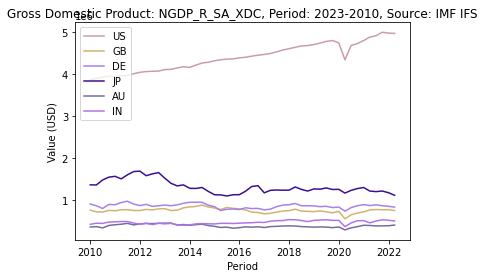

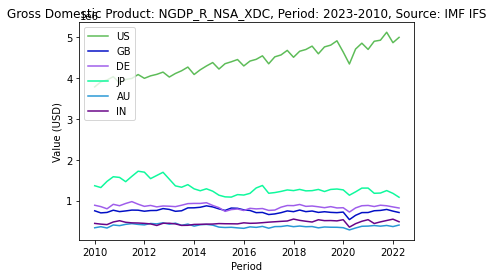

In [59]:
import matplotlib.pyplot as plt;

name = 'Gross Domestic Product'
source = 'Source: IMF IFS';

for code in codes: 
  for country in countries:
      df_tmp = df.loc[(df['Indicator']==code) & (df['Country']==country),['Period','Value_USD']]
      x, y = df_tmp.iloc[:, 0] , df_tmp.iloc[:, 1]
      col = (np.random.random(), np.random.random(), np.random.random())
      plt.plot(x, y, color = col, label = country);
  plt.legend(loc = 'upper left');
  plt.title(f"{name}: {code}, Period: {time_end}-{time_start}, {source}");
  plt.xlabel("Period");
  plt.ylabel("Value (USD)");
  plt.show();


Now, we will save the dataset to csv.

In [60]:
df.to_csv('GDP.csv', header=True)

In this notebook, we looked at an exaple of how to retrieve data from the IMF's JSON RESTful Web Service API. In the next notenbook, we will explore more in depth the methods available in the API.